In [4]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


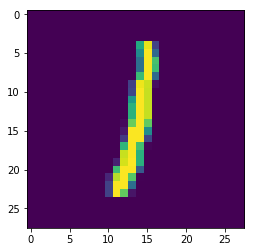

In [2]:
mnist = input_data.read_data_sets("../data/mnist")
plt.imshow(mnist.train.images[4].reshape(28,28))

### generator

In [3]:
# wil take a random noise (z) and return the reconstructed image
def GN(z,reuse=None):
    
    with tf.variable_scope('gen',reuse=reuse):
        layer1 = tf.layers.dense(z,256,activation=tf.nn.relu)
        layer2 = tf.layers.dense(layer1,512,activation=tf.nn.relu)
        output = tf.layers.dense(layer2,784,activation=tf.nn.tanh)

        return output

### discriminator

In [4]:
# will take an image x and will predict whether that belongs
# to data sample or random sample
def DN(X,reuse=None):
    
    with tf.variable_scope('dis',reuse=reuse):
        layer1 = tf.layers.dense(X,256,activation=tf.nn.relu)
        layer2 = tf.layers.dense(layer1,128,activation=tf.nn.relu)
        output = tf.layers.dense(layer2,1,activation=tf.nn.sigmoid)

        return output

In [5]:
# defining placeholders for real image and noise input
with tf.name_scope('placeholders'):
    real_image = tf.placeholder(tf.float32,shape=(None,784))
    z = tf.placeholder(tf.float32,shape=(None,100))

In [6]:
# taking input from the Discriminator and Generator networks
with tf.name_scope('logits'):
    fake_image = GN(z)

    real_logit = DN(real_image)
    fake_logit = DN(fake_image,reuse=True)

### loss

In [8]:
# loss function 
dloss = -tf.reduce_mean(tf.log(real_logit)+tf.log(1. - fake_logit))
gloss = -tf.reduce_mean(tf.log(fake_logit))

In [9]:
# separating the variables for separately training discriminator and generator network
allvars = tf.trainable_variables()
dvars = [var for var in allvars if 'dis' in var.name]
gvars = [var for var in allvars if 'gen' in var.name]

### optimisers

In [10]:
# defining separate optimizers for discriminator and generator
with tf.variable_scope('optimizer',reuse=tf.AUTO_REUSE):
    
    doptimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(dloss,var_list=dvars)
    goptimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(gloss,var_list=gvars)

### global variables 

In [3]:
# defining the global variables
batch_size = 100
epoch = 100

### training

In [12]:
# training
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    for epoch in range(epoch):
        
        # looping over the dataset
        for i in range(mnist.train.num_examples//batch_size):
            
            # taking next batch of data
            batch_data = mnist.train.next_batch(batch_size=batch_size)
            # reshaping the batch of data
            ximage = batch_data[0].reshape((batch_size,784))
            # randomly sampling a noise from uniform distribution
            xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
            
            # optimising
            sess.run(doptimizer,feed_dict={real_image:ximage,z:xsample})
            sess.run(goptimizer,feed_dict={z:xsample})
            
            # printing the loss values
            if(i%500==0 and epoch%10==0):
                l1 = sess.run(dloss,feed_dict={real_image:ximage,z:xsample})
                l2 = sess.run(gloss,feed_dict={z:xsample})
                print("after {} losses : Descriptor : {} Generator : {}\n".format(i,l1,l2))
        
        print("On epoch {}".format(epoch))
        
        # generating samples after each epoch
        cur_sample = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(fake_image,feed_dict={z:cur_sample})
        gen_sample = gen_sample.reshape(28,28)
        
        # saving the image after each epoch
        cv2.imwrite("image_"+str(epoch),gen_sample)
        
        # saving the model after each epoch
        saver.save(sess,'./model.ckpt')